<a href="https://colab.research.google.com/github/usneek/Mural-Restoration/blob/main/PCONVNet_with_cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall keras -y
!pip uninstall keras-nightly -y
!pip uninstall keras-Preprocessing -y
!pip uninstall keras-vis -y
!pip uninstall tensorflow -y

!pip3 install tensorflow-gpu==1.13.1
!pip install keras==2.2.4
!pip install 'h5py < 3.0.0'

Found existing installation: keras 2.7.0
Uninstalling keras-2.7.0:
  Successfully uninstalled keras-2.7.0
Found existing installation: Keras-Preprocessing 1.1.2
Uninstalling Keras-Preprocessing-1.1.2:
  Successfully uninstalled Keras-Preprocessing-1.1.2
Found existing installation: keras-vis 0.4.1
Uninstalling keras-vis-0.4.1:
  Successfully uninstalled keras-vis-0.4.1
Found existing installation: tensorflow 2.7.0
Uninstalling tensorflow-2.7.0:
  Successfully uninstalled tensorflow-2.7.0
     |████████████████████████████████| 345.0 MB 4.1 kB/s 
     |████████████████████████████████| 50 kB 6.3 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 3.2 MB 38.7 MB/s 
     |████████████████████████████████| 367 kB 43.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.utils import conv_utils
from keras import backend as K
from keras.engine import InputSpec
from keras.layers import Conv2D


class PConv2D(Conv2D):
    def __init__(self, *args, n_channels=3, mono=False, **kwargs):
        super().__init__(*args, **kwargs)
        self.input_spec = [InputSpec(ndim=4), InputSpec(ndim=4)]

    def build(self, input_shape):        
        """Adapted from original _Conv() layer of Keras        
        param input_shape: list of dimensions for [img, mask]
        """
        
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
            
        if input_shape[0][channel_axis] is None:
            raise ValueError('The channel dimension of the inputs should be defined. Found `None`.')
            
        self.input_dim = input_shape[0][channel_axis]
        
        # Image kernel
        kernel_shape = self.kernel_size + (self.input_dim, self.filters)
        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='img_kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        # Mask kernel
        self.kernel_mask = K.ones(shape=self.kernel_size + (self.input_dim, self.filters))

        # Calculate padding size to achieve zero-padding
        self.pconv_padding = (
            (int((self.kernel_size[0]-1)/2), int((self.kernel_size[0]-1)/2)), 
            (int((self.kernel_size[0]-1)/2), int((self.kernel_size[0]-1)/2)), 
        )

        # Window size - used for normalization
        self.window_size = self.kernel_size[0] * self.kernel_size[1]
        
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.built = True

    def call(self, inputs, mask=None):
        '''
        We will be using the Keras conv2d method, and essentially we have
        to do here is multiply the mask with the input X, before we apply the
        convolutions. For the mask itself, we apply convolutions with all weights
        set to 1.
        Subsequently, we clip mask values to between 0 and 1
        ''' 

        # Both image and mask must be supplied
        if type(inputs) is not list or len(inputs) != 2:
            raise Exception('PartialConvolution2D must be called on a list of two tensors [img, mask]. Instead got: ' + str(inputs))

        # Padding done explicitly so that padding becomes part of the masked partial convolution
        images = K.spatial_2d_padding(inputs[0], self.pconv_padding, self.data_format)
        masks = K.spatial_2d_padding(inputs[1], self.pconv_padding, self.data_format)

        # Apply convolutions to mask
        mask_output = K.conv2d(
            masks, self.kernel_mask, 
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )

        # Apply convolutions to image
        img_output = K.conv2d(
            (images*masks), self.kernel, 
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )        

        # Calculate the mask ratio on each pixel in the output mask
        mask_ratio = self.window_size / (mask_output + 1e-8)

        # Clip output to be between 0 and 1
        mask_output = K.clip(mask_output, 0, 1)

        # Remove ratio values where there are holes
        mask_ratio = mask_ratio * mask_output

        # Normalize iamge output
        img_output = img_output * mask_ratio

        # Apply bias only to the image (if chosen to do so)
        if self.use_bias:
            img_output = K.bias_add(
                img_output,
                self.bias,
                data_format=self.data_format)
        
        # Apply activations on the image
        if self.activation is not None:
            img_output = self.activation(img_output)
            
        return [img_output, mask_output]
    
    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_last':
            space = input_shape[0][1:-1]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_utils.conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding='same',
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            new_shape = (input_shape[0][0],) + tuple(new_space) + (self.filters,)
            return [new_shape, new_shape]
        if self.data_format == 'channels_first':
            space = input_shape[2:]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_utils.conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding='same',
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            new_shape = (input_shape[0], self.filters) + tuple(new_space)
            return [new_shape, new_shape]

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

In [ ]:
import os
import sys
import numpy as np
from datetime import datetime

import tensorflow as tf
from keras.models import Model
from keras.models import load_model
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, UpSampling2D, Dropout, LeakyReLU, BatchNormalization, Activation, Lambda
from keras.layers.merge import Concatenate
from keras.applications import VGG16
from keras import backend as K
from keras.utils.multi_gpu_utils import multi_gpu_model


class PConvUnet(object):

    def __init__(self, img_rows=512, img_cols=512, vgg_weights="imagenet", inference_only=False, net_name='default', gpus=1, vgg_device=None):
        """Create the PConvUnet. If variable image size, set img_rows and img_cols to None
        
        Args:
            img_rows (int): image height.
            img_cols (int): image width.
            vgg_weights (str): which weights to pass to the vgg network.
            inference_only (bool): initialize BN layers for inference.
            net_name (str): Name of this network (used in logging).
            gpus (int): How many GPUs to use for training.
            vgg_device (str): In case of training with multiple GPUs, specify which device to run VGG inference on.
                e.g. if training on 8 GPUs, vgg inference could be off-loaded exclusively to one GPU, instead of
                running on one of the GPUs which is also training the UNet.
        """
        
        # Settings
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.img_overlap = 30
        self.inference_only = inference_only
        self.net_name = net_name
        self.gpus = gpus
        self.vgg_device = vgg_device

        # Scaling for VGG input
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]

        # Assertions
        assert self.img_rows >= 256, 'Height must be >256 pixels'
        assert self.img_cols >= 256, 'Width must be >256 pixels'

        # Set current epoch
        self.current_epoch = 0
        
        # VGG layers to extract features from (first maxpooling layers, see pp. 7 of paper)
        self.vgg_layers = [3, 6, 10]

        # Instantiate the vgg network
        if self.vgg_device:
            with tf.device(self.vgg_device):
                self.vgg = self.build_vgg(vgg_weights)
        else:
            self.vgg = self.build_vgg(vgg_weights)
        
        # Create UNet-like model
        if self.gpus <= 1:
            self.model, inputs_mask = self.build_pconv_unet()
            self.compile_pconv_unet(self.model, inputs_mask)            
        else:
            with tf.device("/cpu:0"):
                self.model, inputs_mask = self.build_pconv_unet()
            self.model = multi_gpu_model(self.model, gpus=self.gpus)
            self.compile_pconv_unet(self.model, inputs_mask)
        
    def build_vgg(self, weights="imagenet"):
        """
        Load pre-trained VGG16 from keras applications
        Extract features to be used in loss function from last conv layer, see architecture at:
        https://github.com/keras-team/keras/blob/master/keras/applications/vgg16.py
        """        
            
        # Input image to extract features from
        img = Input(shape=(self.img_rows, self.img_cols, 3))

        # Mean center and rescale by variance as in PyTorch
        processed = Lambda(lambda x: (x-self.mean) / self.std)(img)
        
        # If inference only, just return empty model        
        if self.inference_only:
            model = Model(inputs=img, outputs=[img for _ in range(len(self.vgg_layers))])
            model.trainable = False
            model.compile(loss='mse', optimizer='adam')
            return model
                
        # Get the vgg network from Keras applications
        if weights in ['imagenet', None]:
            vgg = VGG16(weights=weights, include_top=False)
        else:
            vgg = VGG16(weights=None, include_top=False)
            vgg.load_weights(weights, by_name=True)

        # Output the first three pooling layers
        vgg.outputs = [vgg.layers[i].output for i in self.vgg_layers]        
        
        # Create model and compile
        model = Model(inputs=img, outputs=vgg(processed))
        model.trainable = False
        model.compile(loss='mse', optimizer='adam')

        return model
        
    def build_pconv_unet(self, train_bn=True):      

        # INPUTS
        inputs_img = Input((self.img_rows, self.img_cols, 3), name='inputs_img')
        inputs_mask = Input((self.img_rows, self.img_cols, 3), name='inputs_mask')
        
        # ENCODER
        def encoder_layer(img_in, mask_in, filters, kernel_size, bn=True):
            conv, mask = PConv2D(filters, kernel_size, strides=2, padding='same')([img_in, mask_in])
            if bn:
                conv = BatchNormalization(name='EncBN'+str(encoder_layer.counter))(conv, training=train_bn)
            conv = Activation('relu')(conv)
            encoder_layer.counter += 1
            return conv, mask
        encoder_layer.counter = 0
        
        e_conv1, e_mask1 = encoder_layer(inputs_img, inputs_mask, 64, 7, bn=False)
        e_conv2, e_mask2 = encoder_layer(e_conv1, e_mask1, 128, 5)
        e_conv3, e_mask3 = encoder_layer(e_conv2, e_mask2, 256, 5)
        e_conv4, e_mask4 = encoder_layer(e_conv3, e_mask3, 512, 3)
        e_conv5, e_mask5 = encoder_layer(e_conv4, e_mask4, 512, 3)
        e_conv6, e_mask6 = encoder_layer(e_conv5, e_mask5, 512, 3)
        e_conv7, e_mask7 = encoder_layer(e_conv6, e_mask6, 512, 3)
        e_conv8, e_mask8 = encoder_layer(e_conv7, e_mask7, 512, 3)
        
        # DECODER
        def decoder_layer(img_in, mask_in, e_conv, e_mask, filters, kernel_size, bn=True):
            up_img = UpSampling2D(size=(2,2))(img_in)
            up_mask = UpSampling2D(size=(2,2))(mask_in)
            concat_img = Concatenate(axis=3)([e_conv,up_img])
            concat_mask = Concatenate(axis=3)([e_mask,up_mask])
            conv, mask = PConv2D(filters, kernel_size, padding='same')([concat_img, concat_mask])
            if bn:
                conv = BatchNormalization()(conv)
            conv = LeakyReLU(alpha=0.2)(conv)
            return conv, mask
            
        d_conv9, d_mask9 = decoder_layer(e_conv8, e_mask8, e_conv7, e_mask7, 512, 3)
        d_conv10, d_mask10 = decoder_layer(d_conv9, d_mask9, e_conv6, e_mask6, 512, 3)
        d_conv11, d_mask11 = decoder_layer(d_conv10, d_mask10, e_conv5, e_mask5, 512, 3)
        d_conv12, d_mask12 = decoder_layer(d_conv11, d_mask11, e_conv4, e_mask4, 512, 3)
        d_conv13, d_mask13 = decoder_layer(d_conv12, d_mask12, e_conv3, e_mask3, 256, 3)
        d_conv14, d_mask14 = decoder_layer(d_conv13, d_mask13, e_conv2, e_mask2, 128, 3)
        d_conv15, d_mask15 = decoder_layer(d_conv14, d_mask14, e_conv1, e_mask1, 64, 3)
        d_conv16, d_mask16 = decoder_layer(d_conv15, d_mask15, inputs_img, inputs_mask, 3, 3, bn=False)
        outputs = Conv2D(3, 1, activation = 'sigmoid', name='outputs_img')(d_conv16)
        
        # Setup the model inputs / outputs
        model = Model(inputs=[inputs_img, inputs_mask], outputs=outputs)

        return model, inputs_mask    

    def compile_pconv_unet(self, model, inputs_mask, lr=0.0002):
        model.compile(
            optimizer = Adam(lr=lr),
            loss=self.loss_total(inputs_mask),
            metrics=[self.PSNR]
        )

    def loss_total(self, mask):
        """
        Creates a loss function which sums all the loss components 
        and multiplies by their weights. See paper eq. 7.
        """
        def loss(y_true, y_pred):

            # Compute predicted image with non-hole pixels set to ground truth
            y_comp = mask * y_true + (1-mask) * y_pred

            # Compute the vgg features. 
            if self.vgg_device:
                with tf.device(self.vgg_device):
                    vgg_out = self.vgg(y_pred)
                    vgg_gt = self.vgg(y_true)
                    vgg_comp = self.vgg(y_comp)
            else:
                vgg_out = self.vgg(y_pred)
                vgg_gt = self.vgg(y_true)
                vgg_comp = self.vgg(y_comp)
            
            # Compute loss components
            l1 = self.loss_valid(mask, y_true, y_pred)
            l2 = self.loss_hole(mask, y_true, y_pred)
            l3 = self.loss_perceptual(vgg_out, vgg_gt, vgg_comp)
            l4 = self.loss_style(vgg_out, vgg_gt)
            l5 = self.loss_style(vgg_comp, vgg_gt)
            l6 = self.loss_tv(mask, y_comp)

            # Return loss function
            return l1 + 6*l2 + 0.05*l3 + 120*(l4+l5) + 0.1*l6

        return loss

    def loss_hole(self, mask, y_true, y_pred):
        """Pixel L1 loss within the hole / mask"""
        return self.l1((1-mask) * y_true, (1-mask) * y_pred)
    
    def loss_valid(self, mask, y_true, y_pred):
        """Pixel L1 loss outside the hole / mask"""
        return self.l1(mask * y_true, mask * y_pred)
    
    def loss_perceptual(self, vgg_out, vgg_gt, vgg_comp): 
        """Perceptual loss based on VGG16, see. eq. 3 in paper"""       
        loss = 0
        for o, c, g in zip(vgg_out, vgg_comp, vgg_gt):
            loss += self.l1(o, g) + self.l1(c, g)
        return loss
        
    def loss_style(self, output, vgg_gt):
        """Style loss based on output/computation, used for both eq. 4 & 5 in paper"""
        loss = 0
        for o, g in zip(output, vgg_gt):
            loss += self.l1(self.gram_matrix(o), self.gram_matrix(g))
        return loss
    
    def loss_tv(self, mask, y_comp):
        """Total variation loss, used for smoothing the hole region, see. eq. 6"""

        # Create dilated hole region using a 3x3 kernel of all 1s.
        kernel = K.ones(shape=(3, 3, mask.shape[3], mask.shape[3]))
        dilated_mask = K.conv2d(1-mask, kernel, data_format='channels_last', padding='same')

        # Cast values to be [0., 1.], and compute dilated hole region of y_comp
        dilated_mask = K.cast(K.greater(dilated_mask, 0), 'float32')
        P = dilated_mask * y_comp

        # Calculate total variation loss
        a = self.l1(P[:,1:,:,:], P[:,:-1,:,:])
        b = self.l1(P[:,:,1:,:], P[:,:,:-1,:])        
        return a+b

    def fit_generator(self, generator, *args, **kwargs):
        """Fit the U-Net to a (images, targets) generator
        Args:
            generator (generator): generator supplying input image & mask, as well as targets.
            *args: arguments to be passed to fit_generator
            **kwargs: keyword arguments to be passed to fit_generator
        """
        self.model.fit_generator(
            generator,
            *args, **kwargs
        )
    def fit(self , x,y , *args, **kwargs):
        self.model.fit(x , y ,*args, **kwargs)    
        
    def summary(self):
        """Get summary of the UNet model"""
        print(self.model.summary())

    def load(self, filepath, train_bn=True, lr=0.0002):

        # Create UNet-like model
        self.model, inputs_mask = self.build_pconv_unet(train_bn)
        self.compile_pconv_unet(self.model, inputs_mask, lr) 

        # Load weights into model
        self.model.load_weights(filepath)        

    @staticmethod
    def PSNR(y_true, y_pred):
        """
        PSNR is Peek Signal to Noise Ratio, see https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio
        The equation is:
        PSNR = 20 * log10(MAX_I) - 10 * log10(MSE)
        
        Our input is scaled with be within the range -2.11 to 2.64 (imagenet value scaling). We use the difference between these
        two values (4.75) as MAX_I        
        """        
        #return 20 * K.log(4.75) / K.log(10.0) - 10.0 * K.log(K.mean(K.square(y_pred - y_true))) / K.log(10.0) 
        return - 10.0 * K.log(K.mean(K.square(y_pred - y_true))) / K.log(10.0) 

    @staticmethod
    def current_timestamp():
        return datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    
    @staticmethod
    def l1(y_true, y_pred):
        """Calculate the L1 loss used in all loss calculations"""
        if K.ndim(y_true) == 4:
            return K.mean(K.abs(y_pred - y_true), axis=[1,2,3])
        elif K.ndim(y_true) == 3:
            return K.mean(K.abs(y_pred - y_true), axis=[1,2])
        else:
            raise NotImplementedError("Calculating L1 loss on 1D tensors? should not occur for this network")
    
    @staticmethod
    def gram_matrix(x, norm_by_channels=False):
        """Calculate gram matrix used in style loss"""
        
        # Assertions on input
        assert K.ndim(x) == 4, 'Input tensor should be a 4d (B, H, W, C) tensor'
        assert K.image_data_format() == 'channels_last', "Please use channels-last format"        
        
        # Permute channels and get resulting shape
        x = K.permute_dimensions(x, (0, 3, 1, 2))
        shape = K.shape(x)
        B, C, H, W = shape[0], shape[1], shape[2], shape[3]
        
        # Reshape x and do batch dot product
        features = K.reshape(x, K.stack([B, C, H*W]))
        gram = K.batch_dot(features, features, axes=2)
        
        # Normalize with channels, height and width
        gram = gram /  K.cast(C * H * W, x.dtype)
        
        return gram
    
    # Prediction functions
    ######################
    def predict(self, sample, **kwargs):
        """Run prediction using this model"""
        return self.model.predict(sample, **kwargs)

In [ ]:
model = PConvUnet(256 , 256,vgg_weights='drive/MyDrive/Roorkee/pytorch_to_keras_vgg16.h5' )
model.summary()
model.load('drive/MyDrive/CEERI SOP/gan_with_cluster6.h5')

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs_img (InputLayer)         (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
inputs_mask (InputLayer)        (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
p_conv2d_1 (PConv2D)            [(None, 128, 128, 64 9472        inputs_img[0][0]                 
                                                                 inputs_mask[0][0]                
__________________________________________________________________________________________________
activation_1 (Activation)       (None

In [ ]:
model_2 = PConvUnet(256 , 256,vgg_weights='drive/MyDrive/Roorkee/pytorch_to_keras_vgg16.h5' )
model_2.summary()
model_2.load('drive/MyDrive/CEERI SOP/gan_without_cluster_2.h5')

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs_img (InputLayer)         (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
inputs_mask (InputLayer)        (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
p_conv2d_1 (PConv2D)            [(None, 128, 128, 64 9472        inputs_img[0][0]                 
                                                                 inputs_mask[0][0]                
__________________________________________________________________________________________________
activation_1 (Activation)       (None

In [ ]:
def plot_sample_data(masked, mask, ori, middle_title='Raw Mask'):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(np.array(masked[:,:,:]*255 , np.uint8))
    axes[0].set_title('Masked Input')
    axes[1].imshow(np.array(mask[:,:,:]*255 , np.uint8))
    axes[1].set_title(middle_title)
    axes[2].imshow(np.array(ori[:,:,:]*255 , np.uint8))
    axes[2].set_title('Target Output')
    plt.show()

In [ ]:
def get_data(x1_paths , x2_paths , y_paths , i , aug = False):
    y = 'drive/MyDrive/CEERI SOP/Dataset/Cluster6/Clean/' + y_paths[i]
    y = cv2.imread(y)
    y = cv2.cvtColor(y, cv2.COLOR_BGR2RGB)
    y = cv2.resize(y , (256 , 256))
    
    img = 'drive/MyDrive/CEERI SOP/Dataset/Cluster6/Damaged/' + x1_paths[i]
    
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img , (256 , 256))
    
    mask = 'drive/MyDrive/CEERI SOP/Dataset/Cluster6/Masks/' + x2_paths[i]
    
    mask = cv2.imread(mask)
    mask = cv2.bitwise_not(mask)
    mask = cv2.resize(mask , (256 , 256))
    
    
    masked_img = deepcopy(img)
    masked_img[mask==0] = 255#plot_sample_data(masked_img, mask, y, middle_title='Raw Mask')
    return [np.expand_dims(masked_img , 0)/255.0 , np.expand_dims(mask , 0)/255.0] , np.expand_dims(y , 0)/255.0

In [ ]:
x1_paths = os.listdir('drive/MyDrive/CEERI SOP/Dataset/Cluster6/Damaged/')
x2_paths = os.listdir('drive/MyDrive/CEERI SOP/Dataset/Cluster6/Masks/')
y_paths = os.listdir('drive/MyDrive/CEERI SOP/Dataset/Cluster6/Clean/')

In [ ]:
epochs = 30000

In [ ]:
import cv2
from copy import deepcopy
import matplotlib.pyplot as plt
for i in range(epochs):
    print(i+1)
    j = i%len(x1_paths)
    x , y = get_data(x1_paths , x2_paths , y_paths , j , np.random.randint(2))
    model.fit(x , y , epochs = 1)
    if i % 200 == 0:
        plot_sample_data(x[0][0], model.predict(x)[0],y[0],middle_title='Prediction')
        model.model.save_weights('drive/MyDrive/CEERI SOP/gan_cluster.h5')

In [ ]:
def get_data(x1_paths , x2_paths , i , aug = False):
    
    img = 'drive/MyDrive/CEERI SOP/Testing/Damaged/120.jpg'
    
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img , (256 , 256))
    
    mask = 'drive/MyDrive/CEERI SOP/Testing/Masks/120.jpg'
    
    mask = cv2.imread(mask)
    mask = cv2.bitwise_not(mask)
    mask = cv2.resize(mask , (256 , 256))
    
    
    masked_img = deepcopy(img)
    masked_img[mask==0] = 255  #plot_sample_data(masked_img, mask, y, middle_title='Raw Mask')
    return [np.expand_dims(masked_img , 0)/255.0 , np.expand_dims(mask , 0)/255.0]

In [ ]:
def plot_sample_data(masked, mask, middle_title='Raw Mask'):
    _, axes = plt.subplots(1, 2, figsize=(20, 5))
    axes[0].imshow(np.array(masked[:,:,:]*255 , np.uint8))
    axes[0].set_title('Masked Input')
    axes[1].imshow(np.array(mask[:,:,:]*255 , np.uint8))
    axes[1].set_title(middle_title)
    plt.show()

In [ ]:
d_path=os.listdir('drive/MyDrive/CEERI SOP/Testing/Damaged/')
m_path=os.listdir('drive/MyDrive/CEERI SOP/Testing/Masks/')

In [ ]:
import cv2
from copy import deepcopy
import matplotlib.pyplot as plt
i=5
print(d_path[i])
x  = get_data(d_path , m_path , i, 0)
plot_sample_data(x[0][0], model.predict(x)[0] ,middle_title='Prediction')

612.jpg


NameError: ignored

612.jpg


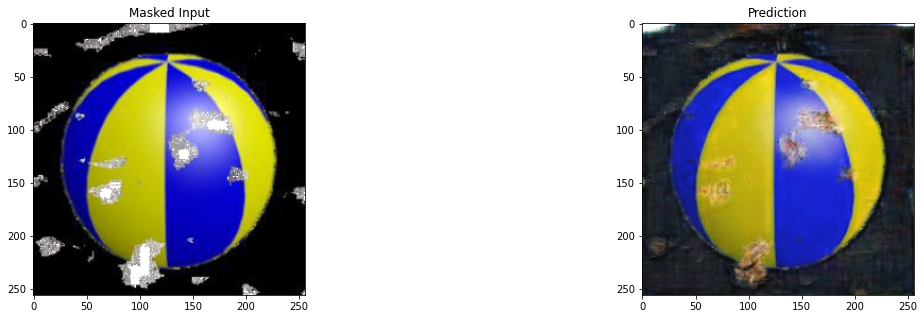

In [ ]:
import cv2
from copy import deepcopy
import matplotlib.pyplot as plt

i=5
print(d_path[i])
x  = get_data(d_path , m_path , i, 0)
plot_sample_data(x[0][0], model_2.predict(x)[0] ,middle_title='Prediction')

In [ ]:
import time

start = time.time()
model_2.predict(x)[0]
end = time.time()
print(end - start)

0.09887337684631348


702.jpg


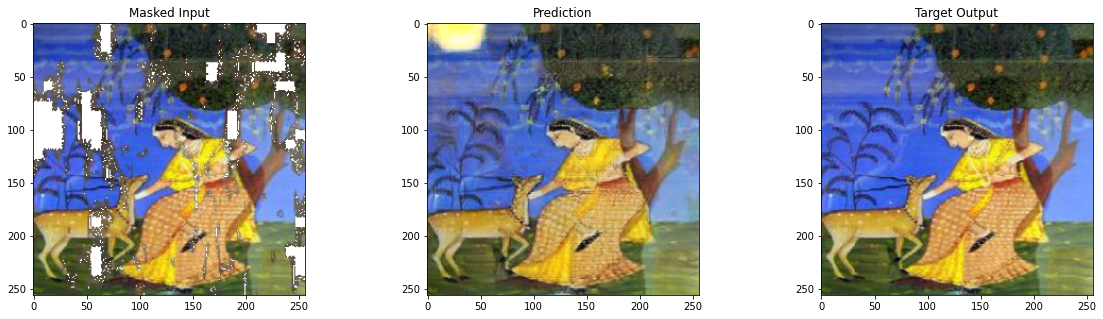

In [ ]:
import cv2
from copy import deepcopy
import matplotlib.pyplot as plt
i=107
print(x1_paths[i])
x , y = get_data(x1_paths , x2_paths , y_paths , i, 0)
plot_sample_data(x[0][0], model.predict(x)[0] ,y[0] ,middle_title='Prediction')